In [ ]:
##############################################################################
##########   Requirement 4 - Taxi Trip Traffic Time Seires Forecast ##########
##########             CBI Intelligence Project                     ##########
##########               Author: Siyuan Liu                         ##########

In [64]:
pip install prophet

     |████████████████████████████████| 65 kB 2.2 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 216 kB 10.7 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641086 sha256=c3931d463c50831ba74d35d1add9b51d52014f18f97192b4b1dfbbcef2bec07c
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [65]:
import psycopg2
import csv
import pandas as pd
import json
import os
import numpy as np
import datetime as dt

import pystan
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly

In [ ]:
pip install uszipcode

     |████████████████████████████████| 454 kB 5.0 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 42 kB 762 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/MyDrive/432_Data Engineering/')


#read in class corpus csv into python
data=pd.read_csv('taxi_2021.csv')

In [ ]:
data.head()

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,02fc5d8c3e8525a49b7514bd6c2b3301c2d6aa79,01/01/2021 12:00:00 AM,01/01/2021 12:15:00 AM,NaN,NaN,41.975171,-87.687516
1,33eb5c7a1439ac1e3ec6d1520e21db8137d1d11b,01/01/2021 12:00:00 AM,01/01/2021 03:30:00 PM,41.792592,-87.769615,NaN,NaN
2,4bcfcfa78f372b705214ee2cba9c765ad6ba5161,01/01/2021 12:00:00 AM,01/01/2021 12:00:00 AM,41.899602,-87.633308,41.899602,-87.633308
3,655bbd9bcb0a78ee003e304ebbe350b21cdd7083,01/01/2021 12:00:00 AM,01/01/2021 12:00:00 AM,41.775929,-87.666596,41.775929,-87.666596
4,7b7b8108de94a518607068a7369ceea1ab2ae924,01/01/2021 12:00:00 AM,01/01/2021 12:00:00 AM,41.836150,-87.648788,41.850266,-87.667569


<div class="alert alert-info">

  
    
## Requirement 4:

- For streetscaping investment and planning, the city of Chicago is interested to forecast daily, weekly, and monthly traffic patterns utilizing the taxi trips for the different zip codes.


</div>

In [ ]:
df_day_trip = data[['Trip ID','Trip Start Timestamp', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude',
       'Dropoff Centroid Latitude','Dropoff Centroid Longitude']].rename(columns={'Trip Start Timestamp' : 'start', 'Pickup Centroid Latitude':'pick_lat', 'Pickup Centroid Longitude':'pick_long',
       'Dropoff Centroid Latitude':'drop_lat','Dropoff Centroid Longitude': 'drop_long'})
df_day_trip.head()


,Trip ID,start,pick_lat,pick_long,drop_lat,drop_long
0,02fc5d8c3e8525a49b7514bd6c2b3301c2d6aa79,01/01/2021 12:00:00 AM,NaN,NaN,41.975171,-87.687516
1,33eb5c7a1439ac1e3ec6d1520e21db8137d1d11b,01/01/2021 12:00:00 AM,41.792592,-87.769615,NaN,NaN
2,4bcfcfa78f372b705214ee2cba9c765ad6ba5161,01/01/2021 12:00:00 AM,41.899602,-87.633308,41.899602,-87.633308
3,655bbd9bcb0a78ee003e304ebbe350b21cdd7083,01/01/2021 12:00:00 AM,41.775929,-87.666596,41.775929,-87.666596
4,7b7b8108de94a518607068a7369ceea1ab2ae924,01/01/2021 12:00:00 AM,41.836150,-87.648788,41.850266,-87.667569


In [ ]:
df_day_trip = df_day_trip.dropna(subset=['pick_lat', 'drop_lat'], how='any')
df_day_trip['pick_lat'] = pd.to_numeric(df_day_trip['pick_lat'],errors='coerce')
df_day_trip['pick_long'] = pd.to_numeric(df_day_trip['pick_long'],errors='coerce')
df_day_trip['drop_lat'] = pd.to_numeric(df_day_trip['drop_lat'],errors='coerce')
df_day_trip['drop_long'] = pd.to_numeric(df_day_trip['drop_long'],errors='coerce')

df_day_trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2623038 entries, 2 to 3072476
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Trip ID    object 
 1   start      object 
 2   pick_lat   float64
 3   pick_long  float64
 4   drop_lat   float64
 5   drop_long  float64
dtypes: float64(4), object(2)
memory usage: 140.1+ MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
df_day_trip['start_date'] = pd.to_datetime(df_day_trip['start'])
df_day_trip['start_date'] = df_day_trip['start_date'].dt.date
df_day_trip['start_date'].isnull().sum()

0

In [ ]:
df_day_trip = df_day_trip.dropna()

In [ ]:
df_day_trip_s = df_day_trip.groupby('start_date').apply(lambda x: x.sample(frac=0.05))
df_day_trip_s.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 131150 entries, (datetime.date(2021, 1, 1), 2357) to (datetime.date(2021, 11, 1), 3072475)
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Trip ID     131150 non-null  object 
 1   start       131150 non-null  object 
 2   pick_lat    131150 non-null  float64
 3   pick_long   131150 non-null  float64
 4   drop_lat    131150 non-null  float64
 5   drop_long   131150 non-null  float64
 6   start_date  131150 non-null  object 
dtypes: float64(4), object(3)
memory usage: 13.8+ MB


In [ ]:
from uszipcode import SearchEngine, SimpleZipcode, Zipcode

search = SearchEngine() #initiate the engine


#mapping the corordinates 
for i, row in df_day_trip_s.iterrows():
    
    results_pick = search.by_coordinates(row['pick_lat'], row['pick_long'], radius = 5)
    df_day_trip_s.loc[i, 'pick_zip_code'] = results_pick[0].zipcode

In [41]:
df_day_trip_s.head()

Trip ID  ... pick_zip_code
start_date                                                 ...              
2021-01-01 2357  f3f5e016b4d6a5c99a32d2c99117998c8eb8083a  ...         60604
           2443  d9863ece34a84428efa64fcc727e470d408d49a1  ...         60018
           1509  69f00d91d2ca24421d911a353316e2a8c2b8debb  ...         60616
           1481  b97416bb0915017e087b55da9be932dec96324bc  ...         60629
           766   6f8c00a26c3299f132031dee33ab8ac15dc02595  ...         60610

[5 rows x 8 columns]

In [48]:
df_day_trip_t = df_day_trip_s[['start_date', 'pick_zip_code']].set_index('start_date')


df = df_day_trip_t.groupby(['start_date', 'pick_zip_code']).size().reset_index(name = 'picks')

In [51]:
print(type(df['start_date'][0]))

<class 'datetime.date'>


In [52]:
df['datetime'] = pd.to_datetime(df['start_date'])
df['week'] =  df['datetime'].dt.week
df['month'] =  df['datetime'].dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [58]:
df = df[df['week']!= 53]

In [90]:
df.head()

,start_date,pick_zip_code,picks,datetime,week,month
103,2021-01-04,60018,21,2021-01-04,1,1
104,2021-01-04,60602,6,2021-01-04,1,1
105,2021-01-04,60603,5,2021-01-04,1,1
106,2021-01-04,60604,26,2021-01-04,1,1
107,2021-01-04,60605,11,2021-01-04,1,1


### Daily Traffic Forecast -     
#### Forecasting orders for zip code: 60657

In [78]:
df_test = df[df['pick_zip_code'] == '60657']
df_daily = df_test[['start_date' , 'picks']]
df_daily = df_daily.rename(columns = {'start_date' : 'ds', 'picks': 'y'})



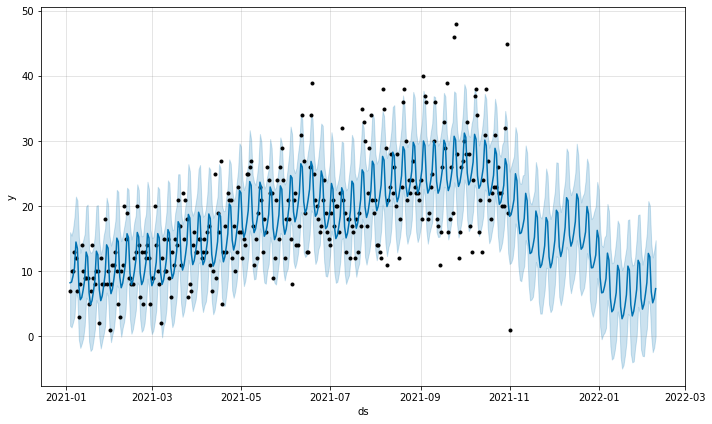

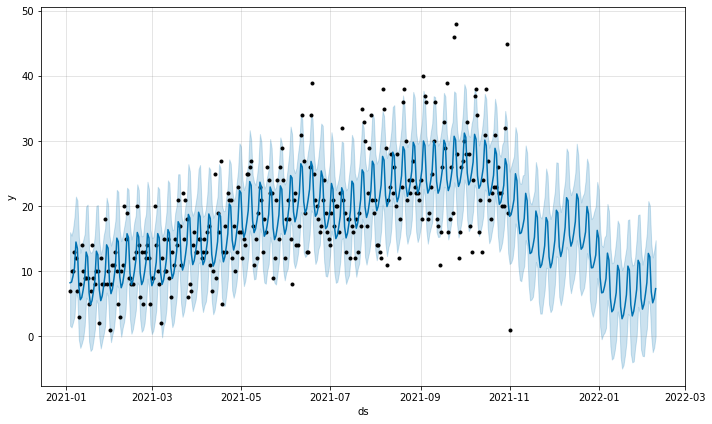

In [82]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_daily) 
future_dates = model.make_future_dataframe(periods = 100, freq='D')
forecast = model.predict(future_dates)

model.plot(forecast)

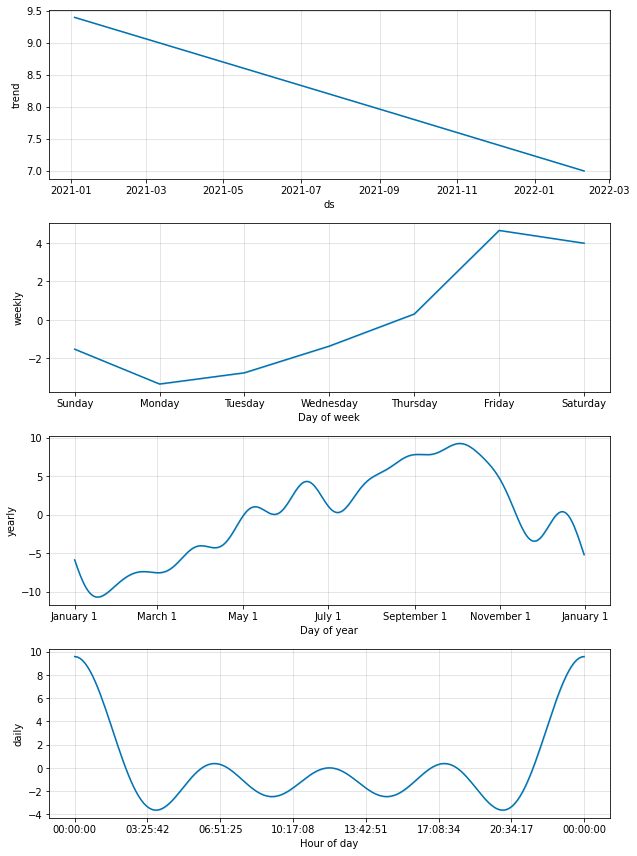

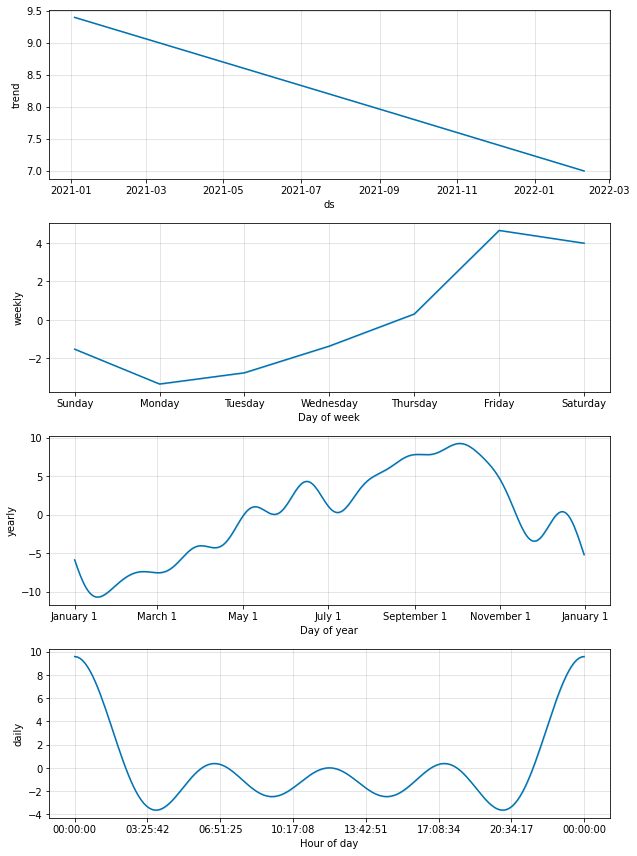

In [83]:
model.plot_components(forecast)

### Weekly Traffic Forecast -     
#### Forecasting orders for zip code: 60657

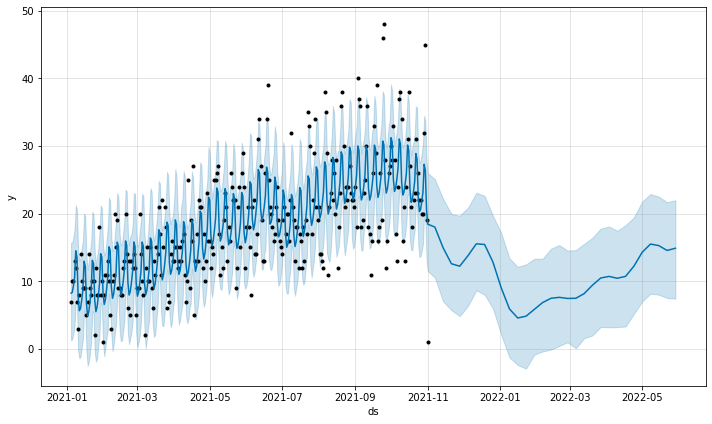

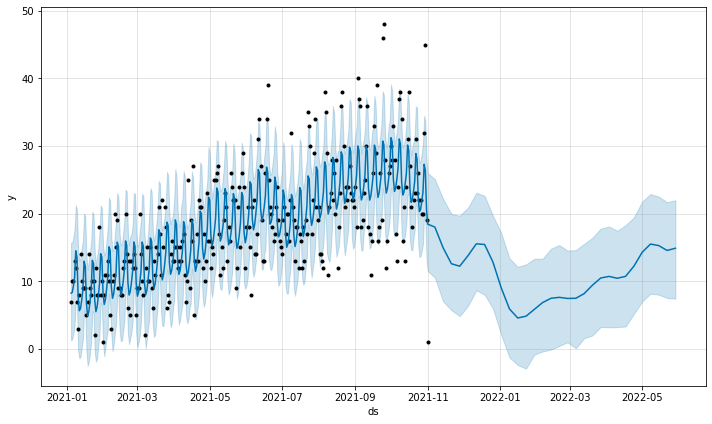

In [84]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_daily) 
future_dates = model.make_future_dataframe(periods = 30, freq='W')
forecast = model.predict(future_dates)

model.plot(forecast)

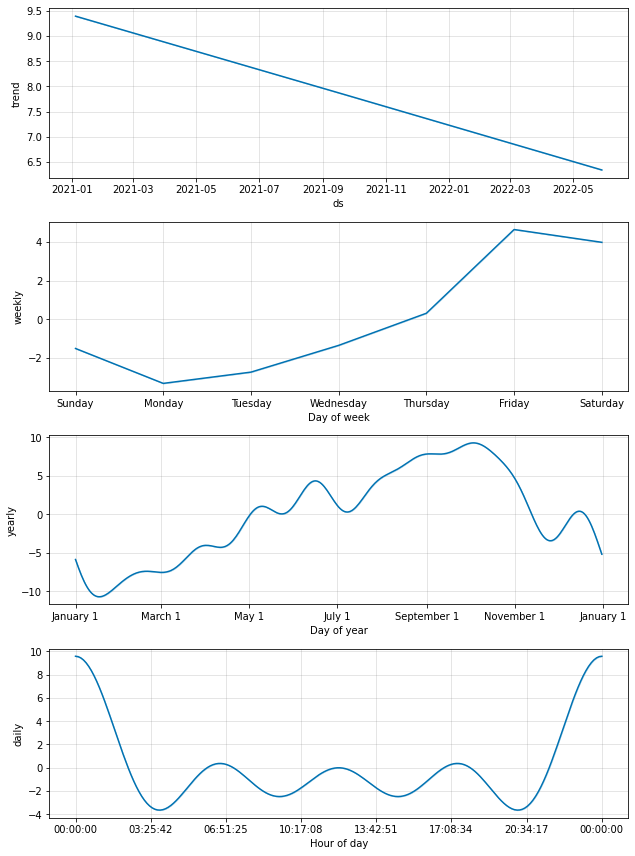

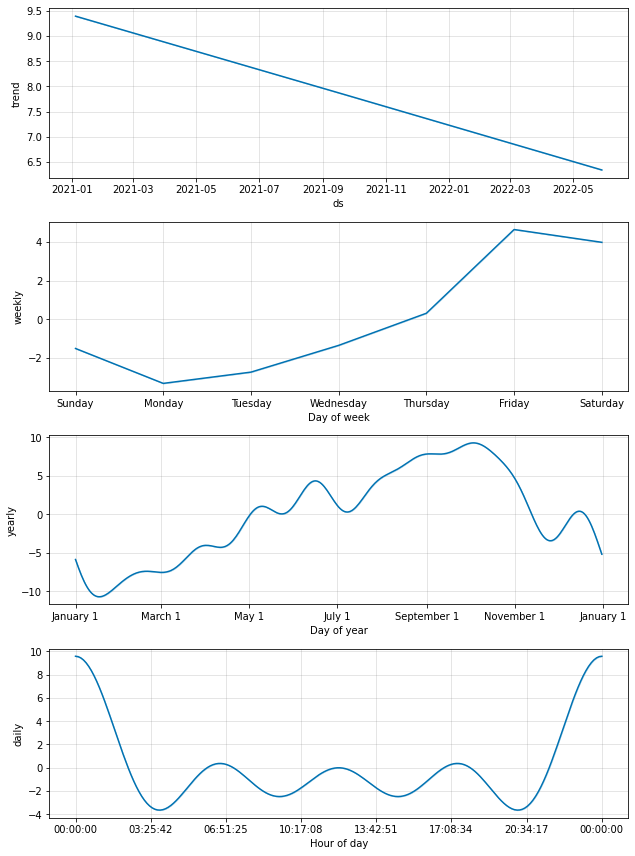

In [85]:
model.plot_components(forecast)

### Monthly Traffic Forecast      
#### Forecasting orders for zip code: 60657

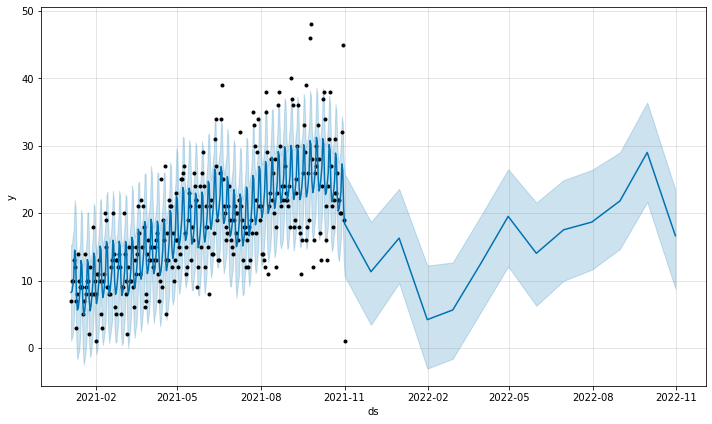

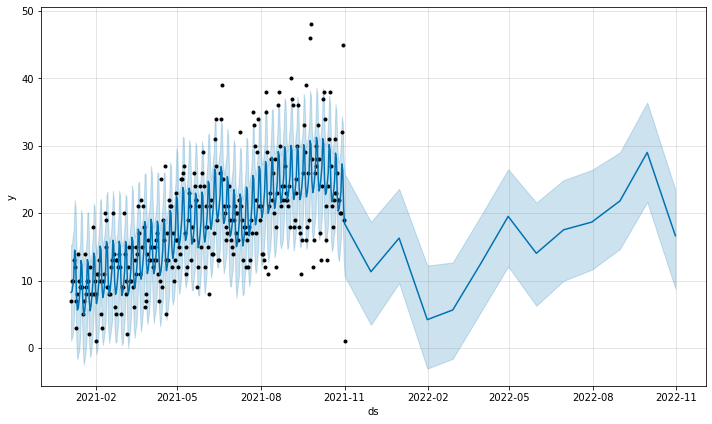

In [87]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_daily) 
future_dates = model.make_future_dataframe(periods = 12, freq='M')
forecast = model.predict(future_dates)

model.plot(forecast)

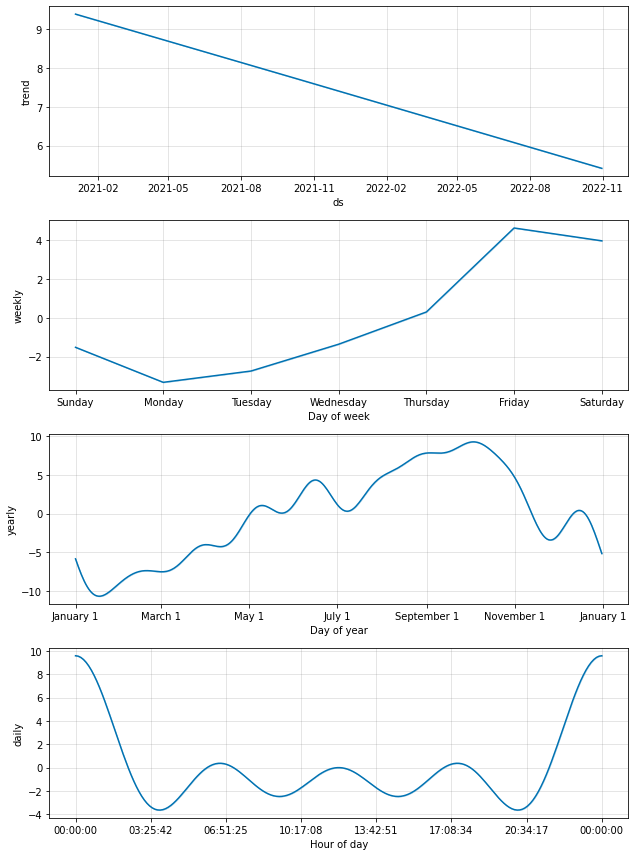

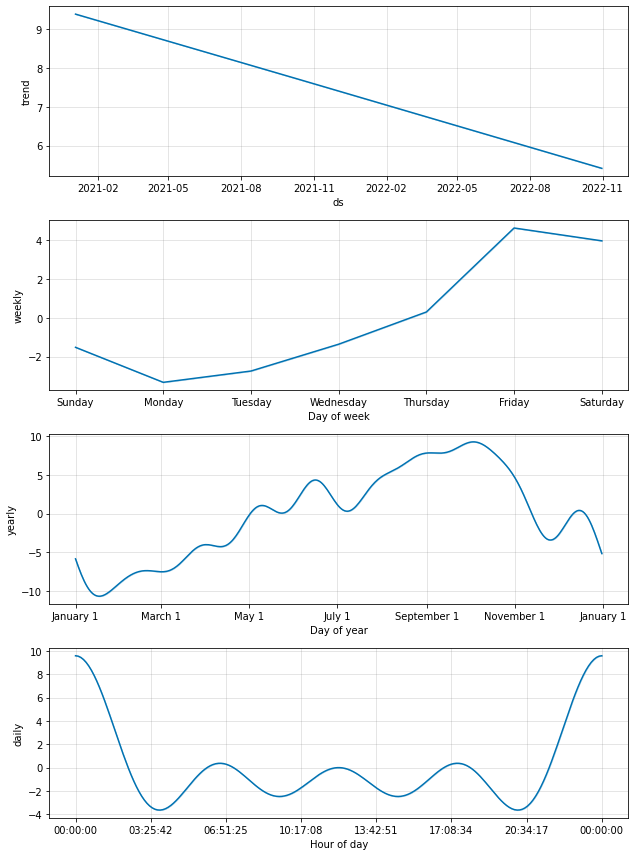

In [88]:
model.plot_components(forecast)

### Daily Traffic Forecast -     
#### Forecasting orders for zip code: all zip codes

In [91]:
df_daily_all = df.groupby(['start_date'])['picks'].sum().reset_index(name = 'y')
df_daily_all = df_daily_all.rename(columns = {'start_date' : 'ds'})


In [97]:
#remove outlier
df_daily_all= df_daily_all[:-1]
df_daily_all.tail()

,ds,y
296,2021-10-27,673
297,2021-10-28,743
298,2021-10-29,799
299,2021-10-30,597
300,2021-10-31,525


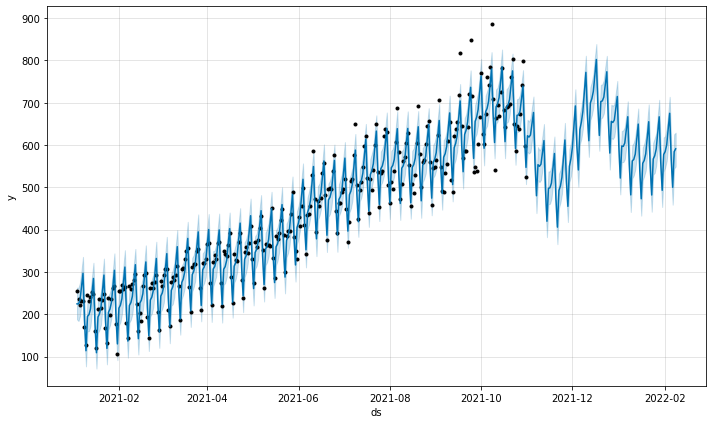

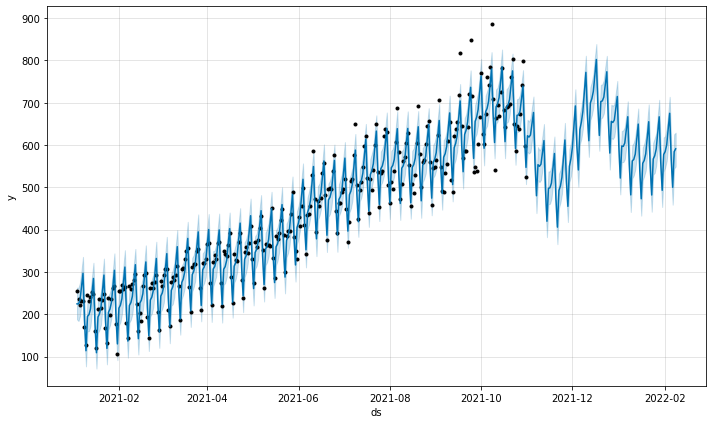

In [100]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_daily_all) 
future_dates = model.make_future_dataframe(periods = 100, freq='D')
forecast = model.predict(future_dates)

model.plot(forecast)

### Weekly Traffic Forecast -     
#### Forecasting orders for zip code: all zip codes

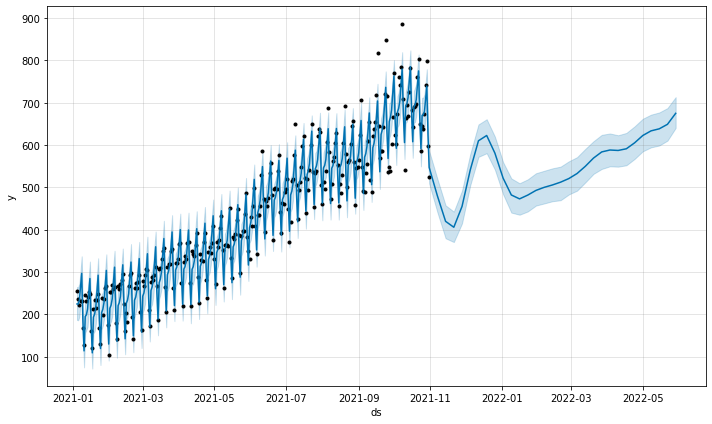

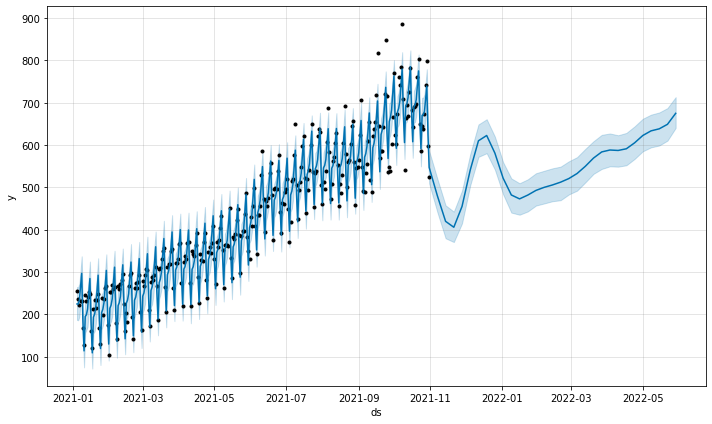

In [102]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_daily_all) 
future_dates = model.make_future_dataframe(periods = 30, freq='W')
forecast = model.predict(future_dates)

model.plot(forecast)

### Monthly Traffic Forecast -     
#### Forecasting orders for zip code: all zip codes

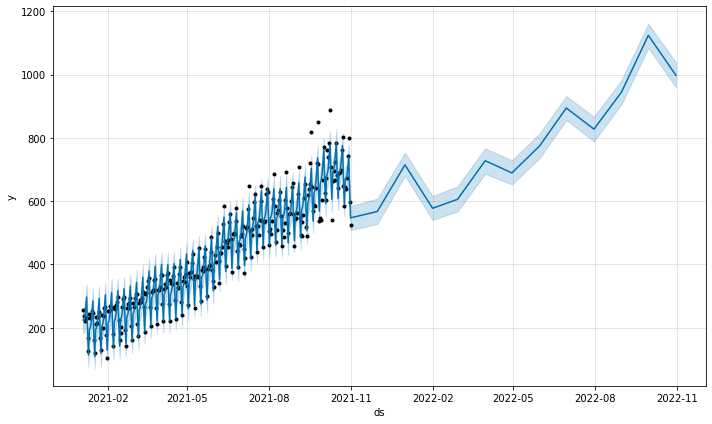

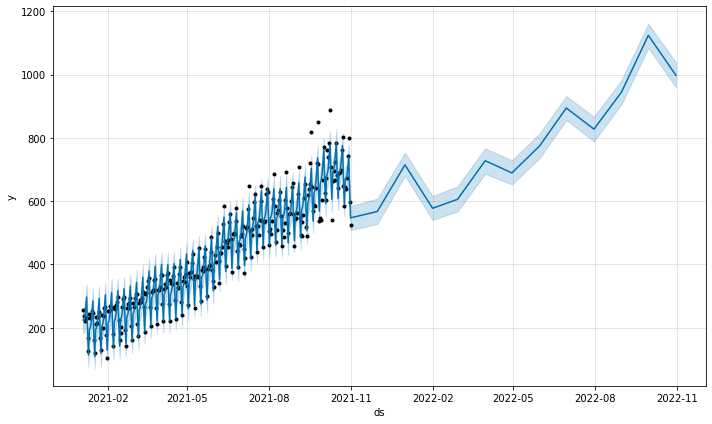

In [103]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_daily_all) 
future_dates = model.make_future_dataframe(periods = 12, freq='M')
forecast = model.predict(future_dates)

model.plot(forecast)